In [1]:
import numpy as np
from matplotlib import pyplot as plt
from boutdata import collect
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from boutdata.data import BoutData

path        = './shared/NORTH/data/'
bdata = BoutData(path)
outputs = bdata['outputs']
options  =bdata['options']

field_keys = bdata['outputs'].keys()


/home/ppfe/s173956/local/venv/north-simulation/lib/python3.9/site-packages/boutdata/data.py:732: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  alwayswarn(
/home/ppfe/s173956/local/venv/north-simulation/lib/python3.9/site-packages/boutdata/data.py:1090: AlwaysWarning: Too many data files, reading most recent ones
  alwayswarn("Too many data files, reading most recent ones")


In [2]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 16})
rcParams['axes.titlepad'] = 20

## Read Options

In [3]:
def get_option(*keys):
    from numpy import sqrt
    val = options
    try:
        for key in keys:
            val = val[key]
        return eval(str(val))
    except:
        print('Error reading option for keys: ', keys)
        return 0

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

In [4]:
R, Te0, N_nuclei, mp, B0, e, mxg, myg = get_options([
    ('north', 'R'), ('north', 'Te0'), ('north', 'N_nuclei'),
    ('north', 'mp'), ('north', 'B0'), ('north', 'e'),
    (['mxg']), (['myg'])])
R, Te0, N_nuclei, mp, B0, e, mxg, myg

(0.25, 10, 2, 1.67e-27, 0.077, 1.6e-19, 2, 0)

In [6]:
print('nx: ', options['mesh']['nx'])
print('ny: ', options['mesh']['ny'])
print('nz: ', options['mesh']['nz'])
print('Lx: ', options['mesh']['Lx'])
print('rho_s: ', options['north']['rho_s'])
print('oci: ', options['north']['oci'])

nx:  64+2*mxg
ny:  1
nz:  256
Lx:  north:a/north:rho_s
rho_s:  sqrt(2*e*Te0/(N_nuclei*mp))/oci
oci:  e*B0/(N_nuclei*mp)


In [7]:
nx_all, ny_all, nz_all = get_options([('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
oci = get_option('north', 'oci')
rho_s = get_option('north', 'rho_s')
Lx = R/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

In [8]:
#%% Read data

field_list  = ['T', 'n', 'phi', 'vort']
par_list    = ['t_array']
# fast_list   = ['t_array', 'n0', 'phi0', 'n1', 'phi1', 'n2', 'phi2', 'T0', 'T1', 'T2']
#%%
data, par, fast = {}, {}, {}

for _field in field_list:
    data[_field] = collect(_field, path = path, xguards = False)

for _par in par_list:
    par[_par] = collect(_par, path = path, xguards = False)

mxsub = 64 mysub = 1 mz = 256

nxpe = 1, nype = 1, npes = 1

Reading from 0: [2-65][0-0] -> [0-63][0-0]


mxsub = 64 mysub = 1 mz = 256

nxpe = 1, nype = 1, npes = 1

Reading from 0: [2-65][0-0] -> [0-63][0-0]


mxsub = 64 mysub = 1 mz = 256

nxpe = 1, nype = 1, npes = 1

Reading from 0: [2-65][0-0] -> [0-63][0-0]


mxsub = 64 mysub = 1 mz = 256

nxpe = 1, nype = 1, npes = 1

Reading from 0: [2-65][0-0] -> [0-63][0-0]


mxsub = 64 mysub = 1 mz = 256

nxpe = 1, nype = 1, npes = 1



In [13]:
dmp_nr = 1

thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(1/(2*nx_inner), Lx+1/(2*nx_inner), nx_inner)

TypeError: Length of x (256) must match number of columns in z (64)

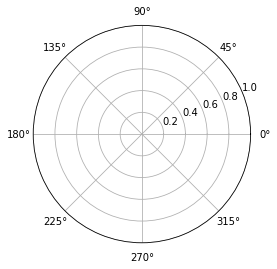

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

plot0 = ax.contourf(thetas, rhos, data['n'][2, :, :, :].squeeze().T, 100, cmap = 'inferno')
plt.colorbar(plot0, ax=ax)

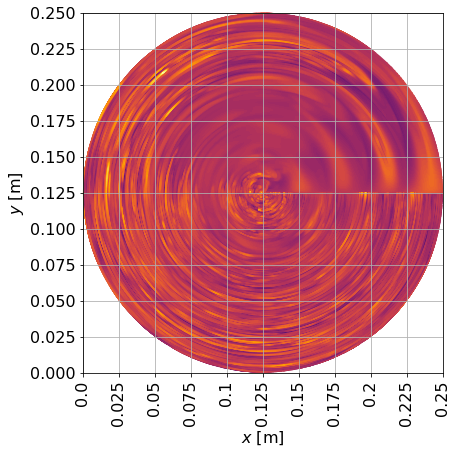

In [51]:
def plot_cyl_data(data, cbarlabel):
    fig = plt.figure(figsize=(5,5))

    # the carthesian axis:
    rect = [0, 0, 1, 1]
    ax_carthesian  = fig.add_axes(rect,zorder=2)
    ax_carthesian.patch.set_alpha(0)
    ax_polar = fig.add_axes(rect, polar=True, frameon=False,zorder=1)

    # the polar axis:
    contour_set = ax_polar.contourf(thetas, rhos, data, 100, cmap = 'inferno')
    ax_polar.grid(False)
    ax_polar.set_xticks([])
    ax_polar.set_rticks([])
    # im_ratio = data.shape[0]/data.shape[1]
    # # plt.colorbar(label=cbarlabel,fraction=0.046*im_ratio, pad=0.04)
    # plt.colorbar(contour_set, ax=ax_polar, label=cbarlabel, fraction=0.046*im_ratio, pad=0.04)
    # plt.colorbar(contour_set, ax=ax_carthesian, label=cbarlabel, fraction=0.046*im_ratio, pad=0.04, alpha=0)

    ticks = np.round(np.linspace(0,Lx,11),3)
    ax_carthesian.set_xlim(0,Lx)
    ax_carthesian.set_ylim(0,Lx)
    ax_carthesian.set_xticks(ticks)
    ax_carthesian.set_yticks(ticks)
    ax_carthesian.set_xticklabels(ticks,rotation = 90)
    ax_carthesian.set_xlabel(r'$x$ [m]')
    ax_carthesian.set_ylabel(r'$y$ [m]')
    ax_carthesian.grid()

plot_cyl_data(data['n'][2, :, :, :].squeeze().T, cbarlabel=r'$n \,\, [\mathrm{m^{-3}}]$')

In [8]:
# Method to change the contour data points
def animate(i):
    ax = plt.gca()
    fig = plt.gcf()
    ax.clear()
    ax.contourf(thetas, rhos, data['n'][i, :, :, :].squeeze().T, 100, cmap = 'inferno', vmin=5.5, vmax=10.5)
    fig.tight_layout()

MovieWriter ffmpeg unavailable; using Pillow instead.


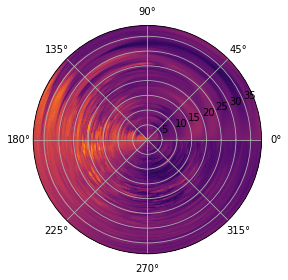

In [10]:
# Call animate method
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ani = animation.FuncAnimation(fig, animate, frames=20, interval=100, blit=False)
ani.save('plots/animation_ne.gif', fps = 20)
plt.show()

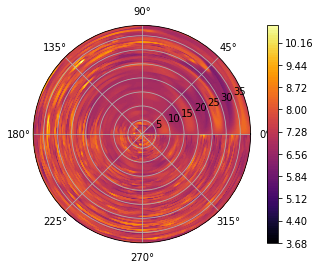